# 数据探索

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# plt.rcParams[u'font.sans-serif'] = ['simhei']
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from scipy import stats


## 训练集(train.csv)探索

In [27]:
train = pd.read_csv('../data/train.csv')
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [28]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [29]:
train.apply(lambda x: sum(x.isnull()))

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

在训练集中没有缺失值，因为给后续工作带来了方便。

## 变量分析

### 相关系数

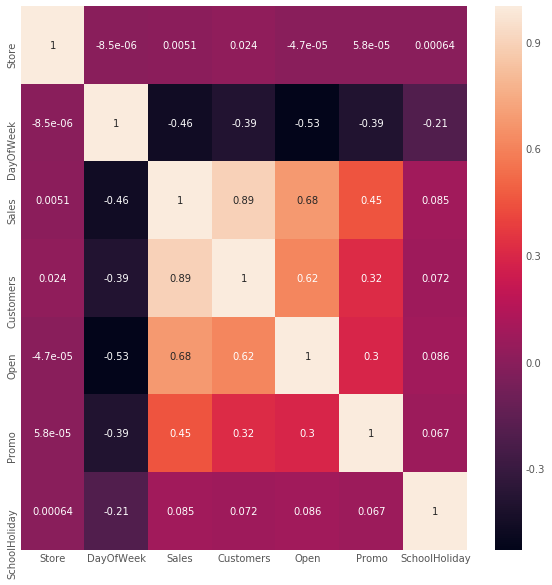

In [30]:
fig = plt.figure(figsize=(10,10))
coff = train.corr()
_ = sns.heatmap(coff, annot=True)

从相关系数的热力图，可以看出：
1. Sales和Customers呈正相关，这是符合逻辑的，更大的客流量带来了更多的销售额，如果没有顾客，销售额肯定为0；
2. Open与Sales和Customers也呈正相关，原因和上面一样；
3. 促销活动也会带来更大的销售额（正相关）
4. DayOfWeek与其他特征都是负相关，说明周末的销售额要小于工作日的销售额

### Sales

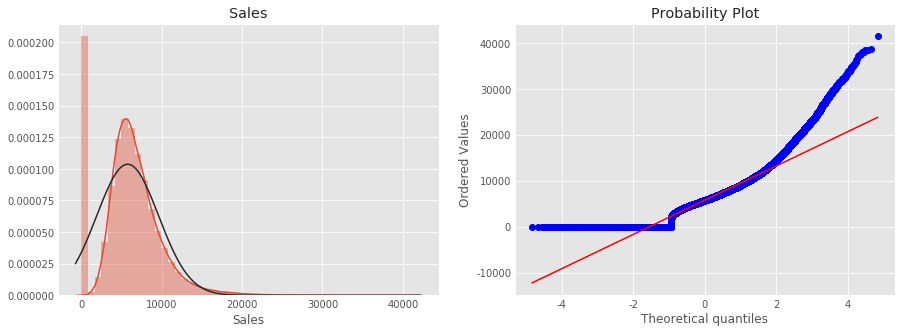

In [31]:
# 观察sales的分布
fig = plt.figure(figsize=(15,5))
_ = plt.subplot(121)
sns.distplot(train['Sales'], fit=stats.norm)
plt.title('Sales')
_ = plt.subplot(122)
res = stats.probplot((train['Sales']), plot=plt)

从上图中可以看出，在训练集中存在销售额为0的情况,并且存在大量的离群值。<br>
整体上看，销售额不是正态分布，存在明显的长尾。需要对Sales进行对数变换。

### Customers V.S. Sales
逻辑上，顾客的数量应该与销售额呈正比。

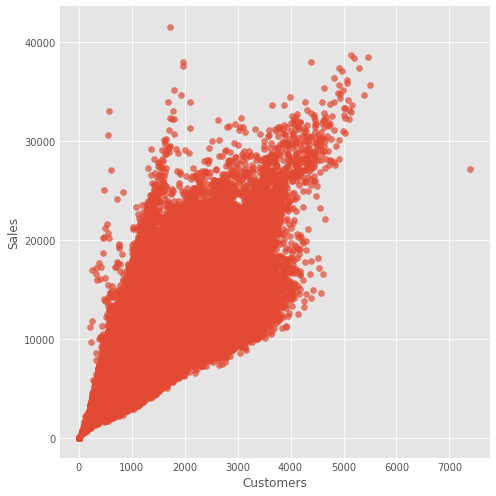

In [32]:
g = sns.FacetGrid(train, size=7)
_ = g.map(plt.scatter, 'Customers', 'Sales', alpha=0.7)

如上图所示，顾客数量与销售额呈正比，但是需要注意，存在部分的离群值。<br>
同时，当顾客数量为0时，销售额也为0，这是符合逻辑的。**因此，对于测试集中的数据，如果Customers=0，即可以预测Sales=0**。同时，销售额为0的情况下，极有可能是因为Open=0。

In [33]:
train[train['Open']==0].describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,172817.000000,172817.000000,172817.0,172817.0,172817.0,172817.000000,172817.000000
mean,558.462987,6.333769,0.0,0.0,0.0,0.064716,0.105684
std,322.771734,1.547688,0.0,0.0,0.0,0.246025,0.307434
min,1.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000
25%,279.000000,7.000000,0.0,0.0,0.0,0.000000,0.000000
50%,560.000000,7.000000,0.0,0.0,0.0,0.000000,0.000000
75%,839.000000,7.000000,0.0,0.0,0.0,0.000000,0.000000
max,1115.000000,7.000000,0.0,0.0,0.0,1.000000,1.000000


从上面的表格，可以说明当Open=0是，Sales和Customers都是0，同时还能看出，大多数商店（≥75%）在星期天不营业。

### DayOfWeek V.S. Sales

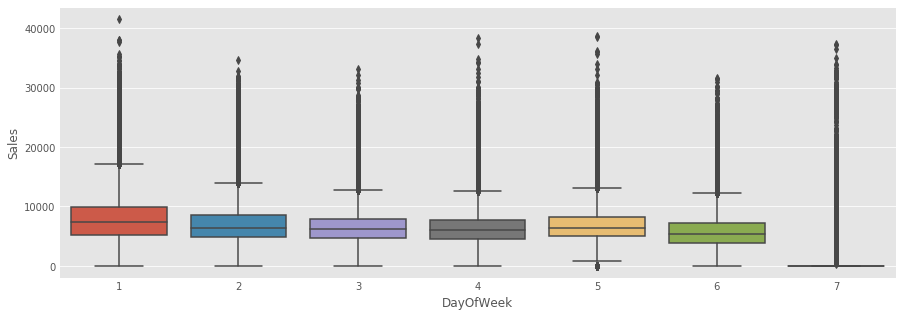

In [34]:
fig = plt.figure(figsize=(15,5))
_ = sns.boxplot(x='DayOfWeek', y='Sales', data=train)

销售额在星期天的时候普遍明显低于其他时间，同时，销售额在星期一的中位数最高。

### Promo V.S. Sales

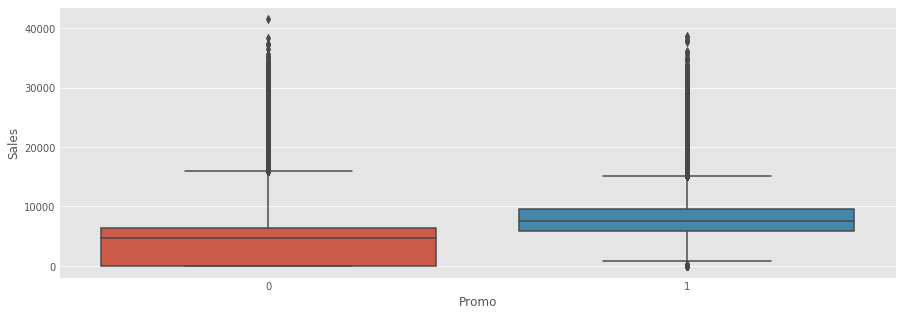

In [35]:
fig = plt.figure(figsize=(15,5))
_ = sns.boxplot(x='Promo', y='Sales', data=train)

促销也会带来明显的销售额提升。

### SchoolHoliday V.S. Sales

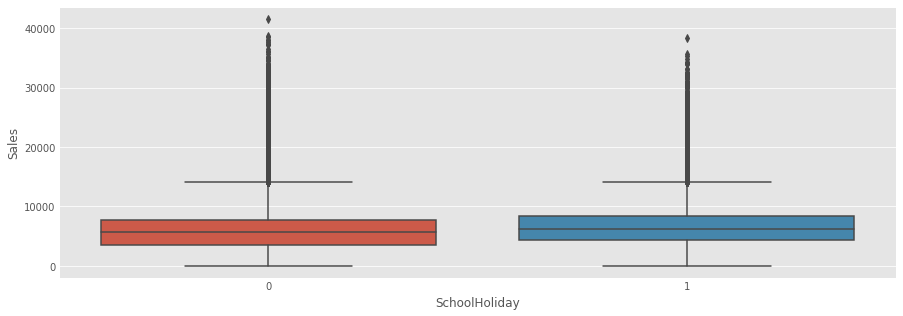

In [36]:
fig = plt.figure(figsize=(15,5))
_ = sns.boxplot(x='SchoolHoliday', y='Sales', data=train)

学校是否放假，对销售额的影响不大。

## 商店信息(store.csv)

In [37]:
store = pd.read_csv('../data/store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [38]:
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [39]:
store.describe(include='object')

,StoreType,Assortment,PromoInterval
count,1115,1115,571
unique,4,3,3
top,a,a,"Jan,Apr,Jul,Oct"
freq,602,593,335


除Promo2, StoreType和Assortment外，其他特征都有缺失值存在。

In [40]:
store.apply(lambda x: sum(x.isnull()))

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

### CompetitionDistance

In [41]:
store.loc[store['CompetitionDistance'].isnull(), :]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


当CompetitionDistance缺失时，其他缺失特征也存在。只有三个样本缺失CompetitionDistance，因此可以认为，这三家商店附近没有竞争对手。在数据集中，距离竞争对手最远的距离是75860，所以可以将缺失值设为99999。

In [42]:
store['CompetitionDistance'] = store['CompetitionDistance'].fillna(99999)

### CompetitionOpenSinceMonth和CompetitionOpenSinceYear 
竞争对手开业年份和开业月份的缺失数量相同，可以设想应该是同一商店发生缺失。

In [43]:
# 提取CompetitionOpenSinceMonth缺失的样本
nan_set = store.loc[store['CompetitionOpenSinceMonth'].isnull(), :]
print('CompetitionOpenSinceMonth 缺失样本数量为:\n%d'%len(nan_set))

# 计算CompetitionOpenSinceMonth缺失样本数量
print('\n同时CompetitionOpenSinceYear 缺失样本数量为:')
print(store.loc[nan_set.index, 'CompetitionOpenSinceYear'].isnull().sum())

CompetitionOpenSinceMonth 缺失样本数量为:
354

同时CompetitionOpenSinceYear 缺失样本数量为:
354


可以判断，对同一商店，同时缺失竞争对手开业年份和开业月份，其中有三个商店还缺失竞争对手的距离信息。<br>
因为缺失的数量较多，所以不能直接忽略，对于这两个特征，有两种处理方式：
1. 将同时缺失距离，月份，年份的样本视为附近没有竞争对手，将距离填充为99999，日期填充为未来某一天；
1. 将缺失值用平均数或者中位数填充；
2. 将这两个特征当做分类变量处理，把缺失值作为单独一类处理；
4. 竞争对手存在与否，对商店的销售量存在一定的影响，可以结合销售额进行填充。

### Promo2SinceWeek， Promo2SinceYear和PromoInterval

In [44]:
# 提取CompetitionOpenSinceMonth缺失的样本
nan_set = store.loc[store['Promo2SinceWeek'].isnull(), :]
print('Promo2SinceWeek 缺失样本数量为:\n%d'%len(nan_set))

# 计算Promo2SinceYear缺失样本数量
print('\nPromo2SinceYear 缺失样本数量为:')
print(store.loc[nan_set.index, 'Promo2SinceYear'].isnull().sum())

# 计算PromoInterval缺失样本数量
print('\nPromoInterval 缺失样本数量为:')
print(store.loc[nan_set.index, 'PromoInterval'].isnull().sum())

Promo2SinceWeek 缺失样本数量为:
544

Promo2SinceYear 缺失样本数量为:
544

PromoInterval 缺失样本数量为:
544


对于促销信息，缺失的也是同一商店。结合第一部分的分析促销对销售额有影响，因此与竞争对手信息一样，可以用平均值或者中位数对缺失值进行填充，也可以结合销售信息进行填充。

## 合并train.csv和store.csv

In [45]:
dataset = pd.merge(train, store, on='Store', how='left')
dataset.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [46]:
# 提取没有缺失值,并且销售额不等于0的商店样本
non_null = dataset.dropna(axis=0).copy()
non_null = non_null[non_null['Sales']!=0]
non_null.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
10,11,5,2015-07-31,10457,1236,1,1,0,1,a,c,960.0,11.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
13,14,5,2015-07-31,6544,710,1,1,0,1,a,a,1300.0,3.0,2014.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct"
14,15,5,2015-07-31,9191,766,1,1,0,1,d,c,4110.0,3.0,2010.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [47]:
non_null.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,267788.000000,267788.000000,267788.000000,267788.000000,267788.0,267788.000000,267788.000000,267788.000000,267788.000000,267788.000000,267788.0,267788.000000,267788.000000
mean,558.893707,3.510083,6538.859620,670.912319,1.0,0.446805,0.190188,4284.955749,7.188369,2008.202660,1.0,22.129154,2011.854168
std,327.501545,1.715496,2712.119174,282.933901,0.0,0.497163,0.392450,5248.464194,3.249346,7.413045,0.0,13.551739,1.673148
min,2.000000,1.000000,297.000000,36.000000,1.0,0.000000,0.000000,40.000000,1.000000,1900.000000,1.0,1.000000,2009.000000
25%,276.000000,2.000000,4649.000000,479.000000,1.0,0.000000,0.000000,600.000000,4.000000,2005.000000,1.0,13.000000,2011.000000
50%,563.000000,3.000000,6082.000000,614.000000,1.0,0.000000,0.000000,2230.000000,7.000000,2009.000000,1.0,18.000000,2012.000000
75%,848.000000,5.000000,7924.000000,799.000000,1.0,1.000000,0.000000,5630.000000,10.000000,2012.000000,1.0,37.000000,2013.000000
max,1111.000000,7.000000,37646.000000,3200.000000,1.0,1.000000,1.000000,27190.000000,12.000000,2015.000000,1.0,48.000000,2015.000000


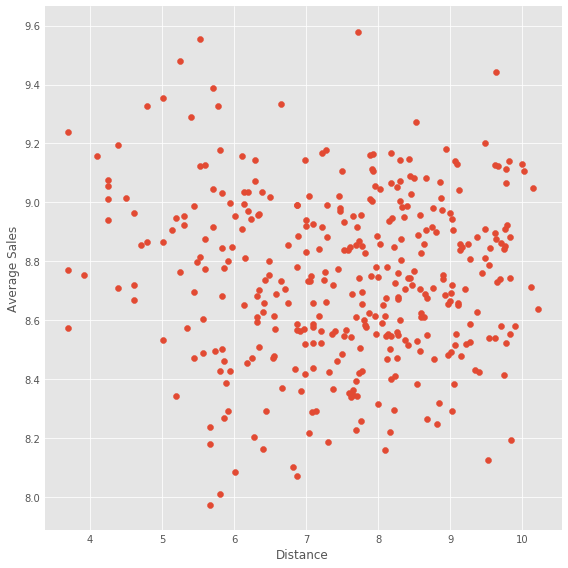

In [48]:
store_sales = pd.DataFrame(non_null[non_null['Sales'] != 0].groupby('Store')['Sales', 'CompetitionDistance'].mean(), columns=['Sales', 'CompetitionDistance'])
store_sales['Sales'] = np.log(store_sales['Sales'])
store_sales['CompetitionDistance'] = np.log(store_sales['CompetitionDistance'])
g = sns.FacetGrid(store_sales, size=8)
_ = g.map(plt.scatter, 'CompetitionDistance', 'Sales')
_ = plt.xlabel('Distance')
_ = plt.ylabel('Average Sales')

竞争对手的远近对商店的销售额的影响不大。两者直接没有明显的关系。

In [49]:
stroe = non_null.groupby('Store').mean()
stroe.head()

,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
Store,,,,,,,,,,,,
2,3.506378,4953.900510,583.998724,1.0,0.451531,0.195153,570.0,11.0,2007.0,1.0,13.0,2010.0
3,3.499358,6942.568678,750.077022,1.0,0.449294,0.200257,14130.0,12.0,2006.0,1.0,14.0,2011.0
11,3.506378,8030.977041,1130.091837,1.0,0.450255,0.184949,960.0,11.0,2011.0,1.0,1.0,2012.0
14,3.499358,5508.567394,631.467266,1.0,0.449294,0.200257,1300.0,3.0,2014.0,1.0,40.0,2011.0
15,3.506378,6672.844388,663.401786,1.0,0.450255,0.184949,4110.0,3.0,2010.0,1.0,14.0,2011.0


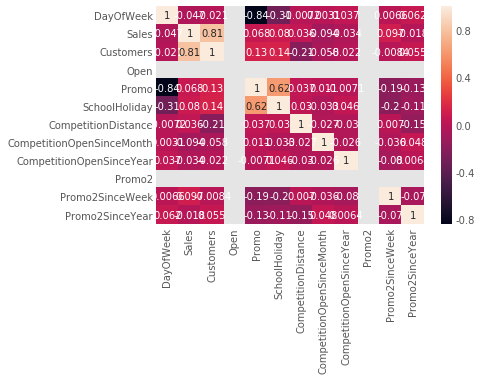

In [50]:
coff = stroe.corr()
sns.heatmap(coff, annot=True)